# Portfolio Optimization
# Chapter 7: Modern Portfolio Theory

Last update: June 27, 2024

Python code examples for Chapters 6-7 of the book:
> Daniel P. Palomar (2024). Portfolio Optimization: Theory and Application. Cambridge University Press.

Contributors:
- [Zé Vinícius](https://github.com/mirca)
- [Daniel Palomar](https://github.com/dppalomar)

This Python session will explore the i.i.d. financial models, starting from the basics and exploring more advanced topics like shrinkage estimators and robust estimators to heavy tails.

## Table of contents
- [Packages](#packages)
- [Downloading market data](#market-data)
- [Buy & Hold portfolios](#buy-and-hold)
- [Comparison of heuristic portfolios (1/N, quintile, and GMRP)](#comparison-heuristic-portfolios)
- [Markowitz's MVP](#markowitz-mvp)
- [GMVP](#gmvp)
- [MSRP](#msrp)
  - [MSRP via nonlinear solver](#msrp-via-nonlinear-solver)
  - [MSRP via bisection](#msrp-via-bisection)
  - [MSRP via Schaible](#msrp-via-schaible)
- [IVP](#ivp)
- [MDP](#mdp)
- [MDCP](#mdcp)
- [Final comparison](#final-comparison)

## Packages <a id="packages"></a>
The following packages are used in the examples:

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt     # for plotting
import seaborn as sns               # for plotting
sns.set(style="darkgrid")           # for plotting
import yfinance as yf               # to download financial data
import empyrical as emp             # performance metrics
import cvxpy as cp                  # interface for convex optimization solvers
from scipy.optimize import minimize, LinearConstraint   # for optimization

## Downloading market data <a id="market-data"></a>
We will load some stock market data and divide it into a training part
(for the estimation of the expected return $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$,
and subsequent portfolio design) and a test part (for the out-of-sample performance evaluation).

In particular, we will start by loading some stock data from three different sectors:

- sector technology: [AAPL](https://finance.yahoo.com/quote/AAPL/profile?p=AAPL),
                     [AMD](https://finance.yahoo.com/quote/AMD/profile?p=AMD),
                     [ADI](https://finance.yahoo.com/quote/ADI/profile?p=ADI).
- sector healthcare:
                     [A](https://finance.yahoo.com/quote/A/profile?p=A),
                     [MOH](https://finance.yahoo.com/quote/MOH/profile?p=MOH),
                     [CVS](https://finance.yahoo.com/quote/CVS/profile?p=CVS)
- sector basic materials: [APD](https://finance.yahoo.com/quote/APD/profile?p=APD),
                          [AA](https://finance.yahoo.com/quote/AA/profile?p=AA),
                          [CF](https://finance.yahoo.com/quote/CF/profile?p=CF).

In [35]:
# download data from YahooFinance
stock_namelist = ["AAPL", "AMD", "ADI", "A", "MOH", "CVS", "APD", "AA", "CF"]
start_date = "2013-01-01"
end_date = "2016-12-31"
prices = yf.download(stock_namelist, start = start_date, end = end_date)

[*********************100%%**********************]  9 of 9 completed


In [36]:
display(type(prices))
display(prices.head())

pandas.core.frame.DataFrame

Price       Adj Close                                                    \
Ticker              A         AA       AAPL        ADI   AMD        APD   
Date                                                                      
2013-01-02  27.193165  20.063438  16.725035  33.990086  2.53  60.345814   
2013-01-03  27.290569  20.241985  16.513926  33.441612  2.49  60.134987   
2013-01-04  27.829487  20.666018  16.053944  32.846786  2.59  60.943233   
2013-01-07  27.628204  20.308933  15.959502  32.947216  2.67  60.886978   
2013-01-08  27.407434  20.308933  16.002462  32.607307  2.67  60.999439   

Price                                            Close  ...       Open  \
Ticker             CF        CVS        MOH          A  ...        MOH   
Date                                                    ...              
2013-01-02  30.673428  37.605328  26.830000  29.957083  ...  27.570000   
2013-01-03  30.528383  37.681015  25.730000  30.064379  ...  26.760000   
2013-01-04  31.212191  37.839977  26.809999  30.658083  ...  25.900000   
2013-01-07  31.095268  37.870243  27.100000  30.436338  ...  26.610001   
2013-01-08  30.639402  37.733994  26.459999  30.193132  ...  27.010000   

Price        Volume                                                            \
Ticker            A        AA       AAPL      ADI       AMD      APD       CF   
Date                                                                            
2013-01-02  8790205   8757720  560518000  3761100  27214800  1312875  5048500   
2013-01-03  5751791   9281232  352965200  2953000  24966900   766321  4025500   
2013-01-04  6432897   7634332  594333600  3502800  22054200  1051813  4534000   
2013-01-07  3589505   9065751  484156400  2377000  25575200   898743  3604000   
2013-01-08  3896925  14181731  458707200  1797800  29140800  1425839  5063000   

Price                        
Ticker          CVS     MOH  
Date                         
2013-01-02  8925500  399600  
2013-01-03  6082200  546700  
2013-01-04  5615700  626500  
2013-01-07  5178100  334000  
2013-01-08  4708000  552900  

[5 rows x 54 columns]

In [37]:
adj_close_prices = prices['Adj Close']
adj_close_prices.head()

Ticker,A,AA,AAPL,ADI,AMD,APD,CF,CVS,MOH
Date,,,,,,,,,
2013-01-02,27.193165,20.063438,16.725035,33.990086,2.53,60.345814,30.673428,37.605328,26.830000
2013-01-03,27.290569,20.241985,16.513926,33.441612,2.49,60.134987,30.528383,37.681015,25.730000
2013-01-04,27.829487,20.666018,16.053944,32.846786,2.59,60.943233,31.212191,37.839977,26.809999
2013-01-07,27.628204,20.308933,15.959502,32.947216,2.67,60.886978,31.095268,37.870243,27.100000
2013-01-08,27.407434,20.308933,16.002462,32.607307,2.67,60.999439,30.639402,37.733994,26.459999


In [38]:
prices_mat = np.asarray(adj_close_prices) # convert data frame into a numpy array (alt: np.ascontiguousarray())
X_log = np.diff(np.log(prices_mat), axis=0) # compute log-returns and returns
X_lin = np.diff(prices_mat, axis=0) / prices_mat[:-1] # prices_mat[:-1] removes the last row of prices_mat, not inplace
T, N = np.shape(X_log) # number of observations (rows) and number of stocks (columns)

We can take a look at the prices of the stocks:

<Axes: title={'center': 'Normalized Stock Prices'}, xlabel='Date'>

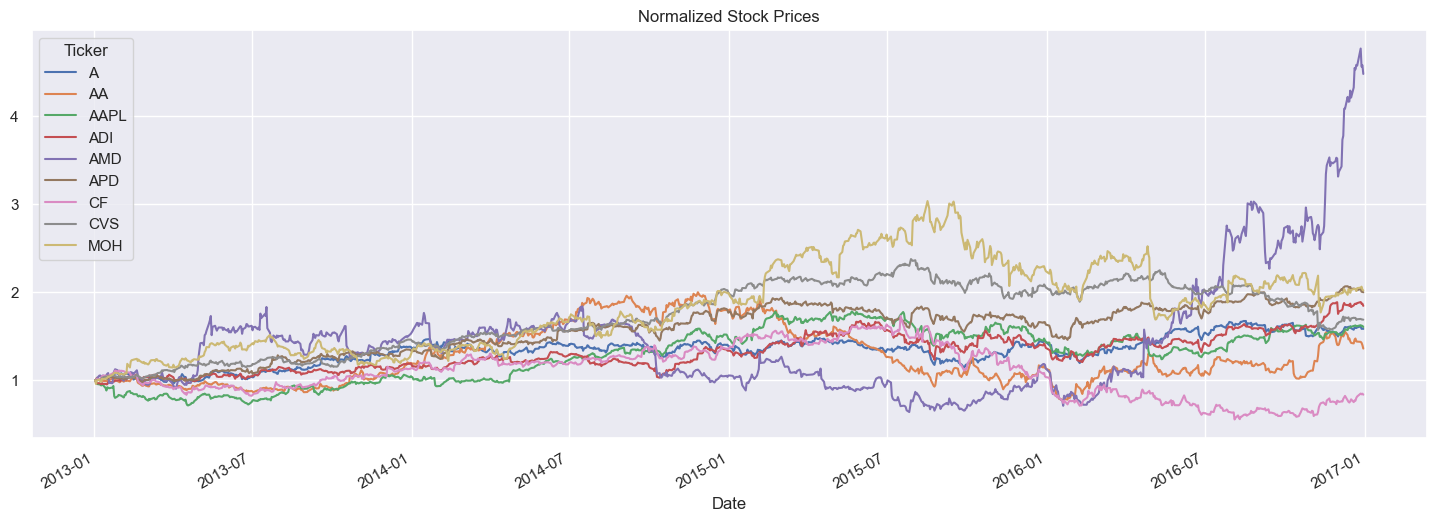

In [39]:
fig, ax = plt.subplots(figsize=(18,6))
(adj_close_prices / adj_close_prices.iloc[0]).plot(title="Normalized Stock Prices", ax=ax)

We now divide the data into a training set and test set:

In [40]:
T_trn = int(0.7*T)  # 70% of data
X_log_trn = X_log[:T_trn,]
X_log_tst = X_log[T_trn:T,]
X_lin_trn = X_lin[:T_trn,]
X_lin_tst = X_lin[T_trn:T,]

### Linear vs log daily returns
We can now use the training set to obtain the sample estimates from the returns
$\mathbf{x}_t$ (i.e., sample mean and sample covariance matrix) as
$$
\begin{aligned}
\hat{\boldsymbol{\mu}} & = \frac{1}{T}\sum_{t=1}^T \mathbf{x}_t\\
\hat{\boldsymbol{\Sigma}} & = \frac{1}{T-1}\sum_{t=1}^T (\mathbf{x}_t - \hat{\boldsymbol{\mu}})(\mathbf{x}_t - \hat{\boldsymbol{\mu}})^T
\end{aligned}
$$

However, it is not totally clear whether we should use linear returns or
log returns to estimate $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$.
Clearly, for the portfolio design we need the expected return $\boldsymbol{\mu}$
and covariance matrix $\boldsymbol{\Sigma}$ of the **linear returns**. There are
three different main philosophies in the estimation procedure for $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$: 

1. estimate them directly from the linear returns (even though linear returns are not supposed to be
easily modeled):
$\hat{\boldsymbol{\mu}} = \hat{\boldsymbol{\mu}}^\textsf{lin}$ and $\hat{\boldsymbol{\Sigma}} = \hat{\boldsymbol{\Sigma}}^\textsf{lin}$
2. estimate them from the log returns (and ignore the approximation error):
$\hat{\boldsymbol{\mu}} = \hat{\boldsymbol{\mu}}^\textsf{log}$ and $\hat{\boldsymbol{\Sigma}} = \hat{\boldsymbol{\Sigma}}^\textsf{log}$
3. estimate them from the log returns but properly transforming them to linear:
$$
\begin{align}
\hat{\boldsymbol{\mu}} & = \exp\left( \hat{\boldsymbol{\mu}}^\textsf{log} + \frac{1}{2}\textsf{diag}(\hat{\boldsymbol{\Sigma}}^\textsf{log})\right) - 1\\
\hat{\Sigma}_{ij} & = \exp\left( \hat{\mu}_i^\textsf{log} + \hat{\mu}_j^\textsf{log} + \frac{1}{2}(\hat{\Sigma}_{ii}^\textsf{log} + \hat{\Sigma}_{jj}^\textsf{log}) \right) \times (\exp(\hat{\Sigma}_{ij}^\textsf{log}) - 1)
\end{align}
$$

In the following, we will explore these three different ways for daily returns. For the comparison we will use the simple Global Minimum Variance Portfolio (GMVP),
$$
\mathbf{w}_\textsf{GMVP} = \frac{1}{\mathbf{1}^T\boldsymbol{\Sigma}^{-1}\mathbf{1}}\boldsymbol{\Sigma}^{-1}\mathbf{1},
$$
as well as the mean-variance portfolio (MVP) as the solution to the problem:
$$\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{maximize}} & \mathbf{w}^{T}\boldsymbol{\mu}-\lambda\mathbf{w}^{T}\boldsymbol{\Sigma}\mathbf{w}\\
\textsf{subject to} & \mathbf{1}^T\mathbf{w}=1.
\end{array}$$


In [41]:
# Method 1: estimate directly from linear returns
mu_lin = np.mean(X_lin_trn, axis=0)
Xc = X_lin_trn - mu_lin  # remove mean (center data)
Sigma_lin = Xc.T @ Xc / (T_trn - 1)
# or more conveniently:
Sigma_lin_ = np.cov(X_lin_trn.T)
np.linalg.norm(Sigma_lin - Sigma_lin_)  # sanity check

np.float64(1.5392711914656797e-19)

In [42]:
# Method 2: estimate directly from log returns
mu_log = np.mean(X_log_trn, axis=0)
Sigma_log = np.cov(X_log_trn.T)

In [43]:
# Method 3: estimate from log returns plus transformation
def get_mu_and_Sigma_log2lin(mu, Sigma):
    N = np.shape(Sigma)[0]
    mu_ = np.exp(mu + 0.5*np.diag(Sigma)) - 1
    Sigma_ = np.empty((N, N))
    for ii in range(N):
        for jj in range(N):
            Sigma_[ii, jj] = np.exp(mu[ii] + mu[jj] + 0.5*(Sigma[ii, ii]+Sigma[jj, jj])) * (np.exp(Sigma[ii, jj])-1)
    return {"mu": mu, "Sigma": Sigma_}  # dict(mu=mu, Sigma=Sigma_)

res = get_mu_and_Sigma_log2lin(mu_log, Sigma_log)
mu_log_trans = res['mu']
Sigma_log_trans = res['Sigma']

Now let's compute and compare the three GMVP portfolios:

In [44]:
def GMVP(Sigma):
    ones = np.ones(Sigma.shape[0])
    Sigma_inv_1 = np.linalg.solve(Sigma, ones) # same as Sigma_inv @ ones
    w = Sigma_inv_1 / (np.sum(Sigma_inv_1))
    return w

# compute the three versions of GMVP
w_GMVP_lin = GMVP(Sigma_lin)
w_GMVP_log = GMVP(Sigma_log)
w_GMVP_log_trans = GMVP(Sigma_log_trans)
w_GMVP_all = pd.DataFrame(np.column_stack([w_GMVP_lin, w_GMVP_log, w_GMVP_log_trans]), columns=['GMVP_lin', 'GMVP_log', 'GMVP_log_trans'], index=stock_namelist)
display(w_GMVP_all)

# alternatively (cleaner):
w_GMVP_all_bis = pd.DataFrame({'GMVP_lin':       w_GMVP_lin, 
                               'GMVP_log':       w_GMVP_log, 
                               'GMVP_log_trans': w_GMVP_log_trans}, index=stock_namelist)
display(w_GMVP_all_bis)

,GMVP_lin,GMVP_log,GMVP_log_trans
AAPL,0.040969,0.038864,0.039192
AMD,0.025729,0.025947,0.026062
ADI,0.126758,0.124251,0.124319
A,0.037703,0.038745,0.038788
MOH,0.013968,0.014300,0.014355
CVS,0.139297,0.140781,0.140740
APD,0.085963,0.085232,0.085322
AA,0.501285,0.502505,0.502054
CF,0.028329,0.029376,0.029168


,GMVP_lin,GMVP_log,GMVP_log_trans
AAPL,0.040969,0.038864,0.039192
AMD,0.025729,0.025947,0.026062
ADI,0.126758,0.124251,0.124319
A,0.037703,0.038745,0.038788
MOH,0.013968,0.014300,0.014355
CVS,0.139297,0.140781,0.140740
APD,0.085963,0.085232,0.085322
AA,0.501285,0.502505,0.502054
CF,0.028329,0.029376,0.029168


Text(0.5, 1.0, 'GMVP allocation')

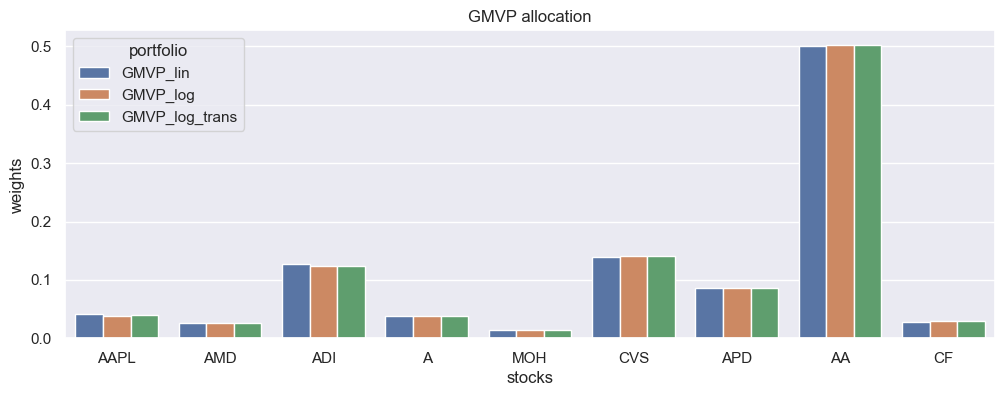

In [45]:
# plot to compare the allocations
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='stocks', y='weights', hue='portfolio', ax=ax,
            data=w_GMVP_all.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='portfolio', value_name='weights'))
ax.set_title("GMVP allocation")

And now the three mean-variance portfolios (MVPs):

,MVP_lin,MVP_log,MVP_log_trans
AAPL,-1.742327e-23,-3.091456e-23,1.119450e-22
AMD,8.346518e-23,-3.339911e-23,9.143836e-24
ADI,-5.825038e-23,-3.774140e-23,7.339132e-23
A,-2.093751e-23,1.405788e-23,1.076607e-22
MOH,-4.583478e-23,-1.939537e-23,-6.736042e-23
CVS,-1.066248e-22,7.671193e-23,6.387407e-23
APD,2.314800e-23,-4.273528e-23,7.073788e-23
AA,6.076733e-01,6.984948e-01,6.992740e-01
CF,3.923267e-01,3.015052e-01,3.007260e-01


Text(0.5, 1.0, 'MVP allocation')

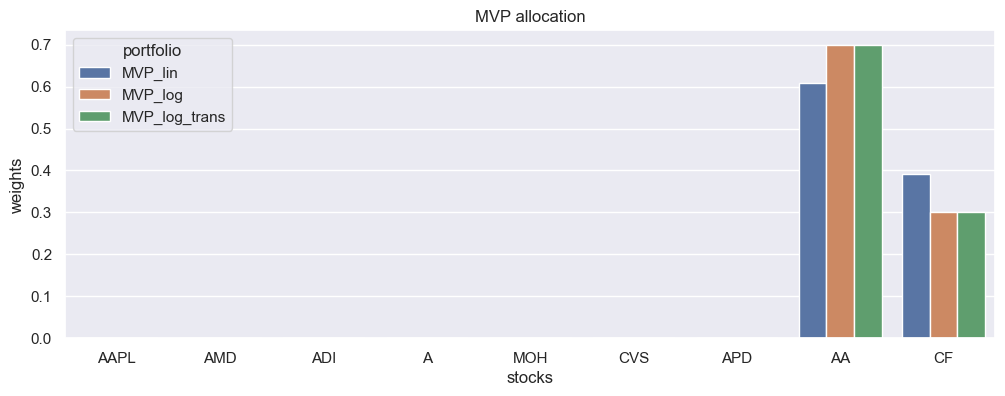

In [46]:
def MVP(mu, Sigma, lmd = 0.5):
    w = cp.Variable(len(mu))
    variance = cp.quad_form(w, Sigma)
    expected_return = w @ mu
    problem = cp.Problem(cp.Minimize(variance - lmd * expected_return), 
                         constraints=[w >= 0, cp.sum(w) == 1])   
    problem.solve()
    return w.value

w_MVP_lin = MVP(mu_lin, Sigma_lin)
w_MVP_log = MVP(mu_log, Sigma_log)
w_MVP_log_trans = MVP(mu_log_trans, Sigma_log_trans)
w_MVP_all = pd.DataFrame(np.column_stack([w_MVP_lin, w_MVP_log, w_MVP_log_trans]), columns=['MVP_lin', 'MVP_log', 'MVP_log_trans'], index=stock_namelist)
display(w_MVP_all)

# plot
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='stocks', y='weights', hue='portfolio',  ax=ax,
            data=w_MVP_all.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='portfolio', value_name='weights'))
ax.set_title("MVP allocation")

Finally, we can do an in-sample evaluation (no need to use the test sample for this):

In [47]:
# compute returns
ret_GMVP = X_lin_trn @ w_GMVP_all
ret_MVP = X_lin_trn @ w_MVP_all

# compute performance measures
df_all = pd.concat([ret_GMVP, ret_MVP], axis=1)
pd.DataFrame({"Sharpe ratio": df_all.apply(emp.sharpe_ratio, axis=0).apply(lambda x: f"{x:.3}"),
              "Volatility":   df_all.apply(emp.annual_volatility, axis=0).apply(lambda x: f"{x:.2%}"),})

,Sharpe ratio,Volatility
GMVP_lin,1.67,14.03%
GMVP_log,1.67,14.03%
GMVP_log_trans,1.67,14.03%
MVP_lin,1.84,17.93%
MVP_log,1.9,16.84%
MVP_log_trans,1.9,16.84%


For the GMVP, which only uses the covariance matrix, clearly there is no apparent difference. This is not unexpected since the daily returns of the stocks are roughly within the interval [-0.04, 0.04] and the approximation $r_t = \log(1 + R_t) \approx R_t$ is very accurate:

In [48]:
pd.DataFrame(np.std(X_lin_trn, axis=0).reshape((-1, len(stock_namelist))), columns=stock_namelist)

,AAPL,AMD,ADI,A,MOH,CVS,APD,AA,CF
0,0.013988,0.019181,0.016181,0.015231,0.031053,0.012964,0.017696,0.010174,0.019334


However, for the mean-variance portfolio, which also uses the expected return,
there is some small difference and the methods can be easily ranked:

1. the best method is to properly model the log-returns and then transform the moments to the linear return case
2. the second best method is to use directly the linear returns to estimate the moments
3. the worst method is to use the log-returns to estimate the moment and then use then as if they were the linear return moments.


Now, another question is whether these differences will become more evident for weekly or monthly rebalancing where
the approximation $r_t = \log(1 + R_t) \approx R_t$ may not be so accurate.

### Linear vs log weekly returns
Let's repeat the previous analysis but using **weekly returns**:

In [49]:
log_returns = pd.DataFrame(X_log, columns=stock_namelist, index=adj_close_prices.index[:-1])
lin_returns = pd.DataFrame(X_lin, columns=stock_namelist, index=adj_close_prices.index[:-1])
log_returns_weekly = emp.aggregate_returns(log_returns, convert_to='weekly')
lin_returns_weekly = emp.aggregate_returns(lin_returns, convert_to='weekly')

# recompute returns
X_weekly_log = np.asarray(log_returns_weekly)
X_weekly_lin = np.asarray(lin_returns_weekly)
T_weekly = X_weekly_log.shape[0]  # number of weeks

# split data into training and set data
T_weekly_trn = int(0.7*T_weekly)  # 70% of data
X_weekly_log_trn = X_weekly_log[:T_weekly_trn, ]
X_weekly_log_tst = X_weekly_log[T_weekly_trn:T_weekly, ]
X_weekly_lin_trn = X_weekly_lin[:T_weekly_trn, ]
X_weekly_lin_tst = X_weekly_lin[T_weekly_trn:T_weekly, ]

# estimate mu and Sigma
mu_weekly_lin = np.mean(X_weekly_lin_trn, axis=0)
Sigma_weekly_lin = np.cov(X_weekly_lin_trn.T)

mu_weekly_log = np.mean(X_weekly_log_trn, axis=0)
Sigma_weekly_log = np.cov(X_weekly_log_trn.T)

res = get_mu_and_Sigma_log2lin(mu_log, Sigma_log)
mu_weekly_log_trans = res['mu']
Sigma_weekly_log_trans = res['Sigma']

,GMVP_weekly_lin,GMVP_weekly_log,GMVP_weekly_log_trans
AAPL,0.163676,0.165559,0.039192
AMD,-0.010274,-0.008186,0.026062
ADI,0.127999,0.124774,0.124319
A,0.098269,0.095847,0.038788
MOH,-0.009158,-0.008817,0.014355
CVS,-0.024863,-0.024595,0.140740
APD,0.025721,0.023149,0.085322
AA,0.644438,0.646375,0.502054
CF,-0.015808,-0.014106,0.029168


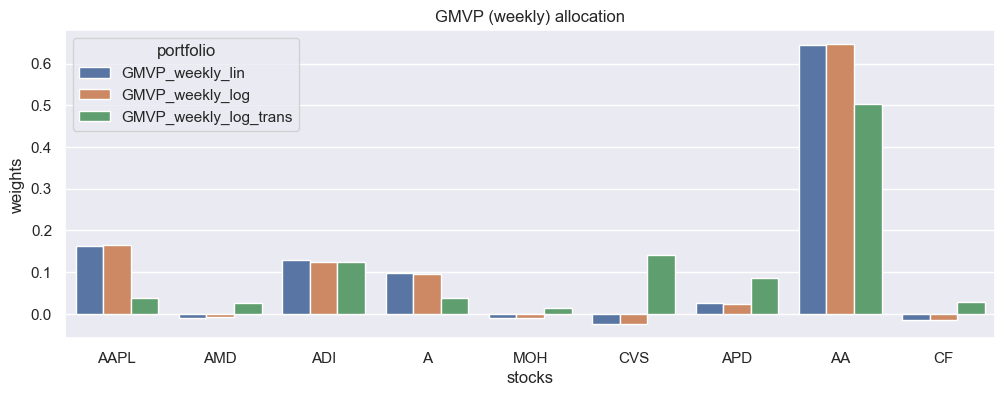

In [50]:
# compute GMVPs
w_GMVP_weekly_lin = GMVP(Sigma_weekly_lin)
w_GMVP_weekly_log = GMVP(Sigma_weekly_log)
w_GMVP_weekly_log_trans = GMVP(Sigma_weekly_log_trans)
w_GMVP_weekly_all = pd.DataFrame(np.column_stack([w_GMVP_weekly_lin, w_GMVP_weekly_log, w_GMVP_weekly_log_trans]), 
                                 columns=['GMVP_weekly_lin', 'GMVP_weekly_log', 'GMVP_weekly_log_trans'], index=stock_namelist)
display(w_GMVP_weekly_all)

# plot to compare the allocations
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='stocks', y='weights', hue='portfolio',  ax=ax,
            data=w_GMVP_weekly_all.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='portfolio', value_name='weights'))
ax.set_title("GMVP (weekly) allocation")
plt.show()

,MVP_weekly_lin,MVP_weekly_log,MVP_weekly_log_trans
AAPL,4.976496e-23,-1.363238e-22,1.119450e-22
AMD,-8.298699e-24,-8.940271e-23,9.143836e-24
ADI,7.391122e-23,-1.273805e-22,7.339132e-23
A,5.042651e-23,-2.576413e-22,1.076607e-22
MOH,1.406915e-24,-4.499568e-23,-6.736042e-23
CVS,2.494602e-23,-7.930497e-23,6.387407e-23
APD,4.975481e-23,-1.257449e-22,7.073788e-23
AA,6.471607e-01,7.419286e-01,6.992740e-01
CF,3.528393e-01,2.580714e-01,3.007260e-01


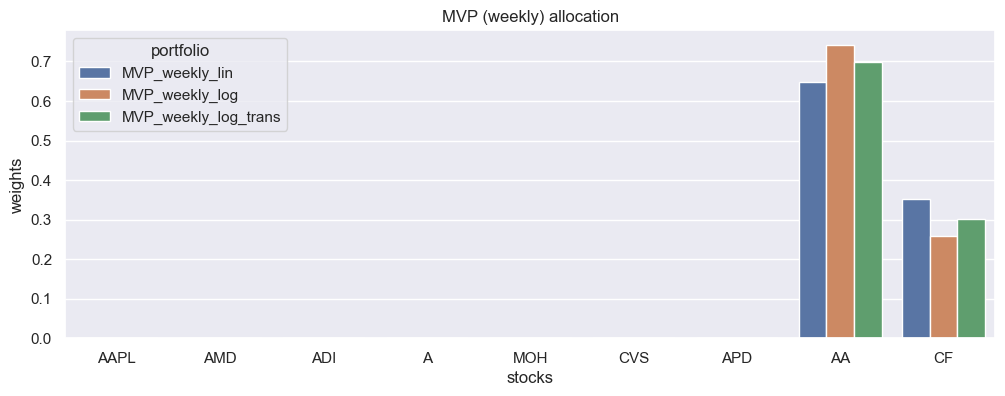

In [51]:
# compute MVPs
w_MVP_weekly_lin = MVP(mu_weekly_lin, Sigma_weekly_lin)
w_MVP_weekly_log = MVP(mu_weekly_log, Sigma_weekly_log)
w_MVP_weekly_log_trans = MVP(mu_weekly_log_trans, Sigma_weekly_log_trans)
w_MVP_weekly_all = pd.DataFrame(np.column_stack([w_MVP_weekly_lin, w_MVP_weekly_log, w_MVP_weekly_log_trans]), columns=['MVP_weekly_lin', 'MVP_weekly_log', 'MVP_weekly_log_trans'], index=stock_namelist)
display(w_MVP_weekly_all)

# plot to compare the allocations
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='stocks', y='weights', hue='portfolio',  ax=ax,
            data=w_MVP_weekly_all.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='portfolio', value_name='weights'))
ax.set_title("MVP (weekly) allocation")
plt.show()

The allocations seem to be very similar.

Let's look at the portfolios performance:

In [52]:
# compute returns
ret_GMVP_weekly = X_weekly_lin_trn @ w_GMVP_weekly_all
ret_MVP_weekly = X_weekly_lin_trn @ w_MVP_weekly_all

# compute performance measures
df_all = pd.concat([ret_GMVP_weekly, ret_MVP_weekly], axis=1)
pd.DataFrame({"Sharpe ratio": df_all.apply(emp.sharpe_ratio, period='weekly').apply(lambda x: f"{x:.3}"),
              "Volatility":   df_all.apply(emp.annual_volatility, period='weekly').apply(lambda x: f"{x:.2%}"),})

,Sharpe ratio,Volatility
GMVP_weekly_lin,1.62,14.39%
GMVP_weekly_log,1.62,14.39%
GMVP_weekly_log_trans,1.56,15.05%
MVP_weekly_lin,1.79,18.16%
MVP_weekly_log,1.86,16.99%
MVP_weekly_log_trans,1.83,17.47%


Again, there is no significant difference for the GMVP. However, for the MVP (which involves also the expected return) there is some small difference.

### Linear vs log monthly returns
Let's repeat the previous analysis but using **monthly returns**:

,GMVP_monthly_lin,GMVP_monthly_log,GMVP_monthly_log_trans
AAPL,0.270536,0.261642,0.039192
AMD,0.216121,0.223440,0.026062
ADI,0.050128,0.045769,0.124319
A,0.171789,0.160487,0.038788
MOH,-0.057997,-0.059381,0.014355
CVS,-0.063933,-0.049317,0.140740
APD,-0.016044,-0.021614,0.085322
AA,0.367818,0.368262,0.502054
CF,0.061583,0.070712,0.029168


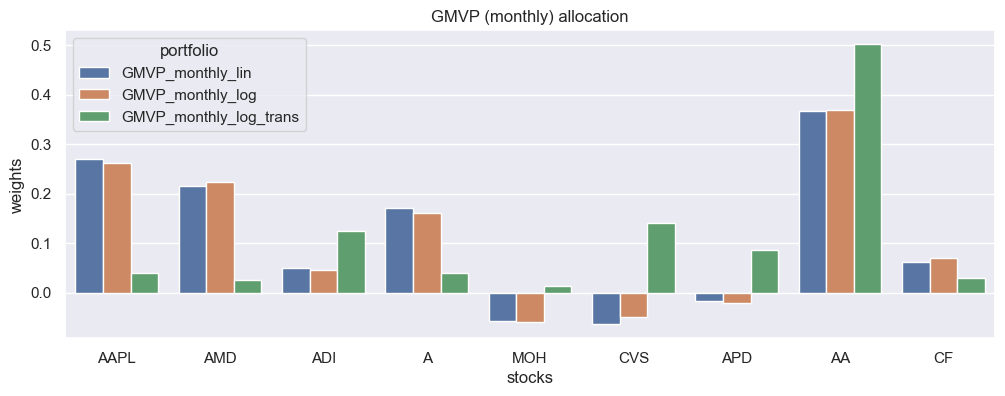

In [53]:
log_returns_monthly = emp.aggregate_returns(log_returns, convert_to='monthly')
lin_returns_monthly = emp.aggregate_returns(lin_returns, convert_to='monthly')

# recompute returns
X_monthly_log = np.ascontiguousarray(log_returns_monthly)
X_monthly_lin = np.ascontiguousarray(lin_returns_monthly)
T_monthly = X_monthly_log.shape[0]  # number of weeks

# split data into training and set data
T_monthly_trn = int(0.7*T_monthly)  # 70% of data
X_monthly_log_trn = X_monthly_log[:T_monthly_trn, ]
X_monthly_log_tst = X_monthly_log[T_monthly_trn:T_monthly, ]
X_monthly_lin_trn = X_monthly_lin[:T_monthly_trn, ]
X_monthly_lin_tst = X_monthly_lin[T_monthly_trn:T_monthly, ]

# estimate mu and Sigma
mu_monthly_lin = np.mean(X_monthly_lin_trn, axis=0)
Sigma_monthly_lin = np.cov(X_monthly_lin_trn.T)

mu_monthly_log = np.mean(X_monthly_log_trn, axis=0)
Sigma_monthly_log = np.cov(X_monthly_log_trn.T)

res = get_mu_and_Sigma_log2lin(mu_log, Sigma_log)
mu_monthly_log_trans = res['mu']
Sigma_monthly_log_trans = res['Sigma']

# compute GMVPs
w_GMVP_monthly_lin = GMVP(Sigma_monthly_lin)
w_GMVP_monthly_log = GMVP(Sigma_monthly_log)
w_GMVP_monthly_log_trans = GMVP(Sigma_monthly_log_trans)
w_GMVP_monthly_all = pd.DataFrame(np.column_stack([w_GMVP_monthly_lin, w_GMVP_monthly_log, w_GMVP_monthly_log_trans]), 
                                  columns=['GMVP_monthly_lin', 'GMVP_monthly_log', 'GMVP_monthly_log_trans'], index=stock_namelist)
display(w_GMVP_monthly_all)

# plot to compare the allocations
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='stocks', y='weights', hue='portfolio', ax=ax,
            data=w_GMVP_monthly_all.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='portfolio', value_name='weights'))
ax.set_title("GMVP (monthly) allocation")
plt.show()

,MVP_monthly_lin,MVP_monthly_log,MVP_monthly_log_trans
AAPL,8.735668e-23,-1.678290e-22,1.119450e-22
AMD,5.173760e-23,-6.197214e-23,9.143836e-24
ADI,-8.165057e-23,-7.520469e-23,7.339132e-23
A,1.419291e-22,-1.492183e-24,1.076607e-22
MOH,2.625127e-23,1.348047e-23,-6.736042e-23
CVS,1.292965e-22,-2.472452e-23,6.387407e-23
APD,7.849523e-23,2.338275e-23,7.073788e-23
AA,6.173313e-01,6.916515e-01,6.992740e-01
CF,3.826687e-01,3.083485e-01,3.007260e-01


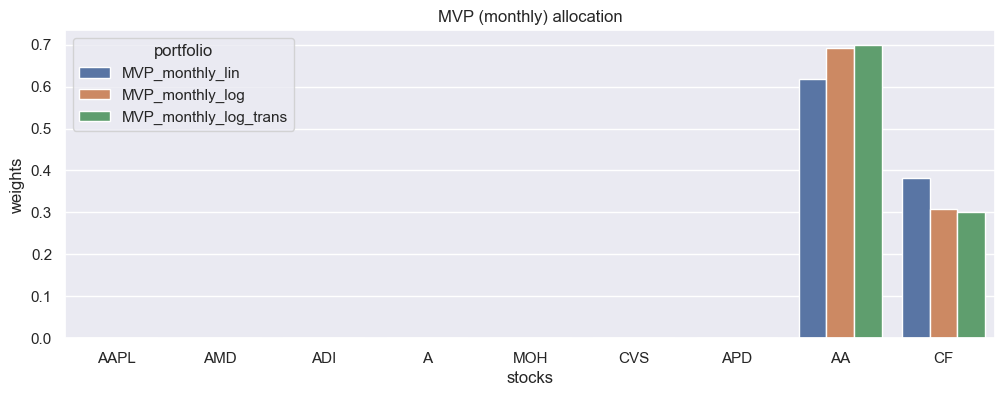

In [54]:
# compute MVPs
w_MVP_monthly_lin = MVP(mu_monthly_lin, Sigma_monthly_lin)
w_MVP_monthly_log = MVP(mu_monthly_log, Sigma_monthly_log)
w_MVP_monthly_log_trans = MVP(mu_monthly_log_trans, Sigma_monthly_log_trans)
w_MVP_monthly_all = pd.DataFrame(np.column_stack([w_MVP_monthly_lin, w_MVP_monthly_log, w_MVP_monthly_log_trans]), columns=['MVP_monthly_lin', 'MVP_monthly_log', 'MVP_monthly_log_trans'], index=stock_namelist)
display(w_MVP_monthly_all)

# plot to compare the allocations
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='stocks', y='weights', hue='portfolio', ax=ax,
            data=w_MVP_monthly_all.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='portfolio', value_name='weights'))
ax.set_title("MVP (monthly) allocation")
plt.show()

The allocations seem to be very similar.

Let's look at the portfolios performance:

In [55]:
# compute returns
ret_GMVP_monthly = X_monthly_lin_trn @ w_GMVP_monthly_all
ret_MVP_monthly = X_monthly_lin_trn @ w_MVP_monthly_all

# compute performance measures
df_all = pd.concat([ret_GMVP_monthly, ret_MVP_monthly], axis=1)
pd.DataFrame({"Sharpe ratio": df_all.apply(emp.sharpe_ratio, period='monthly').apply(lambda x: f"{x:.3}"),
              "Volatility":   df_all.apply(emp.annual_volatility, period='monthly').apply(lambda x: f"{x:.2%}"),})

,Sharpe ratio,Volatility
GMVP_monthly_lin,1.33,13.20%
GMVP_monthly_log,1.36,13.20%
GMVP_monthly_log_trans,1.41,15.13%
MVP_monthly_lin,1.64,19.42%
MVP_monthly_log,1.68,18.46%
MVP_monthly_log_trans,1.68,18.38%


Again, there is no significant difference for the GMVP. However, for the MVP (which involves also the expected return) there is some small difference.

## Buy & Hold (B&H) <a id="buy-and-hold"></a>
Buy & Hold simply means that we allocate the whole budget to one stock and we stick to it. Since we have $N=9$ stocks in our universe, we can define $N=9$ different B&H portfolios, which we will store as column vectors.

In [56]:
# a B&H portfolio is trivially the zero vector with a one on the stock held
w_BnH = np.eye(N)
BnH_names = ["B&H - " + name for name in stock_namelist]
pd.DataFrame(w_BnH, columns=BnH_names, index=stock_namelist)

,B&H - AAPL,B&H - AMD,B&H - ADI,B&H - A,B&H - MOH,B&H - CVS,B&H - APD,B&H - AA,B&H - CF
AAPL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AMD,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
A,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
MOH,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
CVS,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
APD,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can now compute the performance of those $N=9$ portfolios in the training data with the package `empyrical`:

In [57]:
# compute returns of all B&H portfolios
ret_BnH = X_lin @ w_BnH
ret_BnH_trn = ret_BnH[:T_trn, ]
ret_BnH_tst = ret_BnH[T_trn:, ]

# convert to dataframes
ret_BnH_df = pd.DataFrame(ret_BnH, columns=BnH_names, index=adj_close_prices.index[:-1])
ret_BnH_trn_df = pd.DataFrame(ret_BnH_trn, columns=BnH_names, index=adj_close_prices.index[:T_trn])
ret_BnH_tst_df = pd.DataFrame(ret_BnH_tst, columns=BnH_names, index=adj_close_prices.index[T_trn:-1])
ret_BnH_df.head()

,B&H - AAPL,B&H - AMD,B&H - ADI,B&H - A,B&H - MOH,B&H - CVS,B&H - APD,B&H - AA,B&H - CF
Date,,,,,,,,,
2013-01-02,0.003582,0.008899,-0.012622,-0.016136,-0.015810,-0.003494,-0.004729,0.002013,-0.040999
2013-01-03,0.019747,0.020948,-0.027854,-0.017787,0.040161,0.013441,0.022399,0.004219,0.041974
2013-01-04,-0.007233,-0.017279,-0.005883,0.003058,0.030888,-0.000923,-0.003746,0.000800,0.010817
2013-01-07,-0.007991,0.000000,0.002692,-0.010317,0.000000,0.001847,-0.014660,-0.003598,-0.023616
2013-01-08,0.027008,-0.002198,-0.015629,-0.002606,-0.014981,0.013481,0.034974,0.008626,0.001134


In [58]:
# compute performance measures
pd.DataFrame({"Sharpe ratio (in-sample)":     ret_BnH_trn_df.apply(emp.sharpe_ratio).apply(lambda x: f"{x:.3}"),
              "Sharpe ratio (out-of-sample)": ret_BnH_tst_df.apply(emp.sharpe_ratio).apply(lambda x: f"{x:.3}"),
              "Annual return (in-sample)":     ret_BnH_trn_df.apply(emp.annual_return).apply(lambda x: f"{x:.2%}"),
              "Annual return (out-of-sample)": ret_BnH_tst_df.apply(emp.annual_return).apply(lambda x: f"{x:.2%}"),
              "Annual volatility (in-sample)":     ret_BnH_trn_df.apply(emp.annual_volatility).apply(lambda x: f"{x:.2%}"),
              "Annual volatility (out-of-sample)": ret_BnH_tst_df.apply(emp.annual_volatility).apply(lambda x: f"{x:.2%}"),
             })

,Sharpe ratio (in-sample),Sharpe ratio (out-of-sample),Annual return (in-sample),Annual return (out-of-sample),Annual volatility (in-sample),Annual volatility (out-of-sample)
B&H - AAPL,0.462,0.985,8.10%,22.37%,22.22%,23.25%
B&H - AMD,0.241,0.647,2.76%,21.36%,30.47%,46.47%
B&H - ADI,0.703,0.336,15.89%,5.31%,25.70%,23.88%
B&H - A,0.7,0.875,15.07%,20.22%,24.19%,24.49%
B&H - MOH,0.0807,2.16,-7.91%,321.64%,49.33%,80.04%
B&H - CVS,1.05,0.746,21.50%,13.25%,20.59%,19.12%
B&H - APD,0.474,-0.478,9.86%,-30.62%,28.11%,50.07%
B&H - AA,1.8,-0.804,31.96%,-18.78%,16.16%,22.61%
B&H - CF,1.27,-0.283,40.88%,-18.98%,30.71%,42.04%


Note how the in-sample (ex ante) performance is not maintained out-of-sample (ex post).

We can compute many other performance measures:

In [59]:
#emp.downside_risk(ret_BnH_trn_df)

To compute the wealth or cumulative P&L, we have two options: one assumes the same quantity is repeateadly invested, whereas the other assumes reinvesting (compounding):

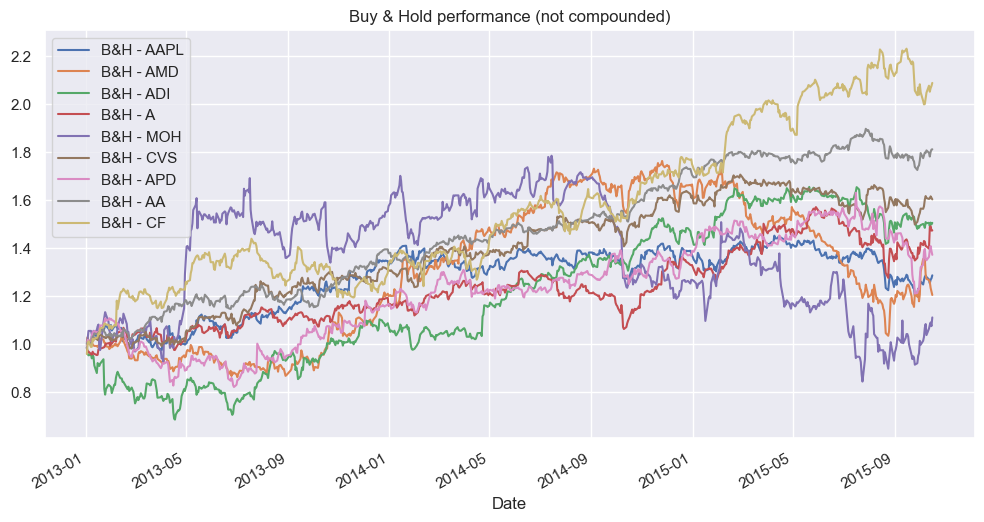

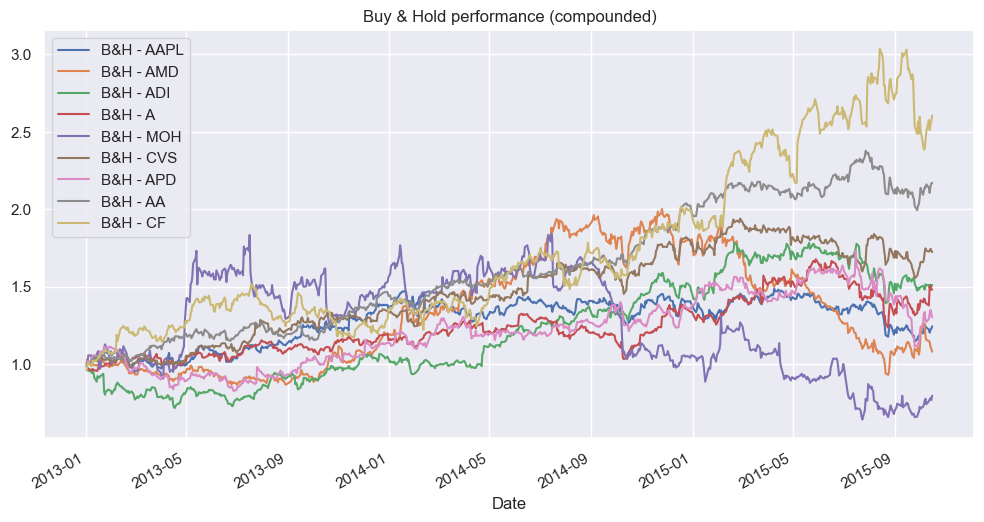

In [60]:
# compute cumulative wealth
wealth_arith_BnH_trn = 1 + np.cumsum(ret_BnH_trn_df)  # initial budget of 1$
wealth_geom_BnH_trn = np.cumprod(1 + ret_BnH_trn_df)  # initial budget of 1$

# plots
fig, ax = plt.subplots(figsize=(12,6))
wealth_arith_BnH_trn.plot(title="Buy & Hold performance (not compounded)", ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(12,6))
wealth_geom_BnH_trn.plot(title="Buy & Hold performance (compounded)", ax=ax)
plt.show()

## Comparison of heuristic portfolios (1/N, quintile, and GMRP) <a id="comparison-heuristic-portfolios"></a>
We are now ready to consider several heuristic portfolio designs (1/N portfolio, quintile portfolio, and GMRP) and compare their performance
(the underlying constraint is simply $\mathbf{w}\ge\mathbf{0}$ and $\mathbf{1}^T\mathbf{w}=1$). 

First, let's estimate $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ from the in-sample log-returns:

In [61]:
mu = np.mean(X_log_trn, axis=0)
Sigma = np.cov(X_log_trn.T)

The **EWP** or **$1/N$ portfolio** allocates equal dollar weight to each stock: $\mathbf{w} = \frac{1}{N}\mathbf{1}$.

In [62]:
w_EWP = np.ones(N)/N
w_EWP

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

**Quintile portfolios** are widely used by practitioners. The idea is to _1_) rank the $N$ stocks, _2_) divide them into five parts, and _3_) long the top part (and possibly short the bottom part). One can rank the stocks in a multitude of ways (typically based on expensive factors that investment funds buy at a premium price). For our experiments, we will consider three possible rankings according to:

1. $\boldsymbol{\mu}$
2. $\boldsymbol{\mu}/\textsf{diag}(\boldsymbol{\Sigma})$
3. $\boldsymbol{\mu}/\sqrt{(\textsf{diag}(\boldsymbol{\Sigma}))}$

In [63]:
# find indices of sorted stocks
i1 = np.argsort(mu)[::-1] # [::-1] is used to reverse an array
i2 = np.argsort(mu/np.diag(Sigma))[::-1]
i3 = np.argsort(mu/np.sqrt(np.diag(Sigma)))[::-1]

# create portfolios
w_QuintP_1 = np.zeros(N) 
w_QuintP_2 = np.zeros(N)
w_QuintP_3 = np.zeros(N) 
w_QuintP_1[i1[:round(N/5)]] = 1./round(N/5)
w_QuintP_2[i2[:round(N/5)]] = 1./round(N/5)
w_QuintP_3[i3[:round(N/5)]] = 1./round(N/5)

w_QuintP_1

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5])

The **global maximum return portfolio (GMRP)** chooses the stock with the hightest return during the in-sample period:

In [64]:
i_max = np.argmax(mu)
w_GMRP = np.zeros(N)
w_GMRP[i_max] = 1.
w_GMRP

array([0., 0., 0., 0., 0., 0., 0., 0., 1.])

We can now compare the allocations of the portfolios:

,QuintP (mu),QuintP (mu/sigma2),QuintP (mu/sigma),EWP,GMRP
AAPL,0.0,0.0,0.0,0.111111,0.0
AMD,0.0,0.0,0.0,0.111111,0.0
ADI,0.0,0.0,0.0,0.111111,0.0
A,0.0,0.0,0.0,0.111111,0.0
MOH,0.0,0.0,0.0,0.111111,0.0
CVS,0.0,0.5,0.0,0.111111,0.0
APD,0.0,0.0,0.0,0.111111,0.0
AA,0.5,0.5,0.5,0.111111,0.0
CF,0.5,0.0,0.5,0.111111,1.0


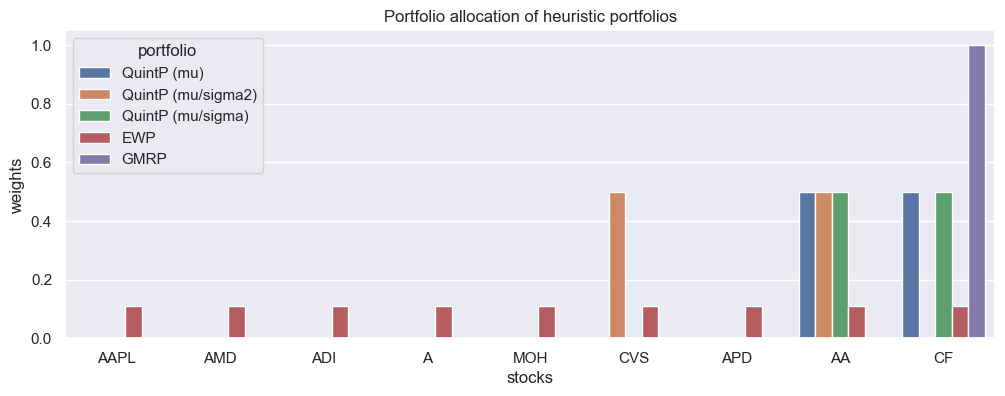

In [65]:
# put together all portfolios
w_heuristic = pd.DataFrame(np.column_stack([w_QuintP_1, w_QuintP_2, w_QuintP_3, w_EWP, w_GMRP]), 
                           columns=['QuintP (mu)', 'QuintP (mu/sigma2)', 'QuintP (mu/sigma)', 'EWP', 'GMRP'], index=stock_namelist)
display(w_heuristic)

# plot to compare the allocations
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='stocks', y='weights', hue='portfolio', ax=ax,
            data=w_heuristic.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='portfolio', value_name='weights'))
ax.set_title("Portfolio allocation of heuristic portfolios")
plt.show()

Then, let's compare the performance in-sample vs out-of-sample:

In [66]:
# compute returns of all heuristic portfolios
ret_heuristic = X_lin @ np.asarray(w_heuristic)
ret_heuristic_trn = ret_heuristic[:T_trn,]
ret_heuristic_tst = ret_heuristic[T_trn:,]

# convert to dataframes
ret_heuristic_df = pd.DataFrame(ret_heuristic, columns=w_heuristic.columns, index=adj_close_prices.index[:-1])
ret_heuristic_trn_df = pd.DataFrame(ret_heuristic_trn, columns=w_heuristic.columns, index=adj_close_prices.index[:T_trn])
ret_heuristic_tst_df = pd.DataFrame(ret_heuristic_tst, columns=w_heuristic.columns, index=adj_close_prices.index[T_trn:-1])
display(ret_heuristic_df.head())

,QuintP (mu),QuintP (mu/sigma2),QuintP (mu/sigma),EWP,GMRP
Date,,,,,
2013-01-02,-0.019493,-0.000740,-0.019493,-0.008811,-0.040999
2013-01-03,0.023096,0.008830,0.023096,0.013028,0.041974
2013-01-04,0.005808,-0.000062,0.005808,0.001167,0.010817
2013-01-07,-0.013607,-0.000875,-0.013607,-0.006183,-0.023616
2013-01-08,0.004880,0.011054,0.004880,0.005534,0.001134


In [67]:
# compute performance measures
pd.DataFrame({"Sharpe ratio (in-sample)":     ret_heuristic_trn_df.apply(emp.sharpe_ratio).apply(lambda x: f"{x:.3}"),
              "Sharpe ratio (out-of-sample)": ret_heuristic_tst_df.apply(emp.sharpe_ratio).apply(lambda x: f"{x:.3}"),
              "Annual return (in-sample)":     ret_heuristic_trn_df.apply(emp.annual_return).apply(lambda x: f"{x:.2%}"),
              "Annual return (out-of-sample)": ret_heuristic_tst_df.apply(emp.annual_return).apply(lambda x: f"{x:.2%}"),
              "Annual volatility (in-sample)":     ret_heuristic_trn_df.apply(emp.annual_volatility).apply(lambda x: f"{x:.2%}"),
              "Annual volatility (out-of-sample)": ret_heuristic_tst_df.apply(emp.annual_volatility).apply(lambda x: f"{x:.2%}"),
             })

,Sharpe ratio (in-sample),Sharpe ratio (out-of-sample),Annual return (in-sample),Annual return (out-of-sample),Annual volatility (in-sample),Annual volatility (out-of-sample)
QuintP (mu),1.73,-0.583,37.80%,-16.81%,19.62%,25.78%
QuintP (mu/sigma2),1.62,-0.118,27.24%,-3.29%,15.61%,16.63%
QuintP (mu/sigma),1.73,-0.583,37.80%,-16.81%,19.62%,25.78%
EWP,1.08,1.11,17.79%,24.15%,16.38%,21.69%
GMRP,1.27,-0.283,40.88%,-18.98%,30.71%,42.04%


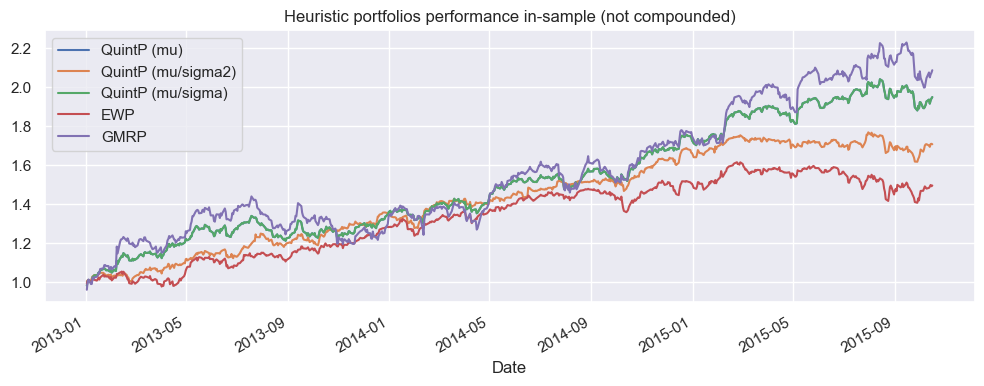

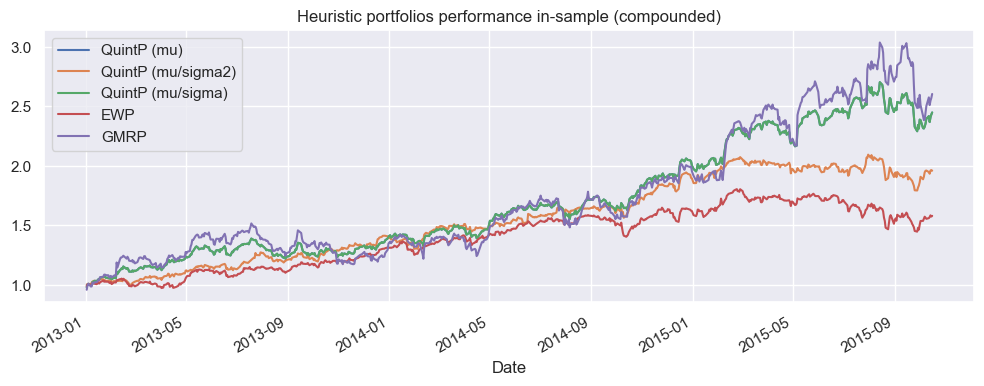

In [68]:
# compute cumulative wealth
wealth_arith_heuristic_trn = 1 + np.cumsum(ret_heuristic_trn_df)  # initial budget of 1$
wealth_arith_heuristic_tst = 1 + np.cumsum(ret_heuristic_tst_df)  # initial budget of 1$
wealth_geom_heuristic_trn = np.cumprod(1 + ret_heuristic_trn_df)  # initial budget of 1$
wealth_geom_heuristic_tst = np.cumprod(1 + ret_heuristic_tst_df)  # initial budget of 1$

# plots in-sample
fig, ax = plt.subplots(figsize=(12,4))
wealth_arith_heuristic_trn.plot(title="Heuristic portfolios performance in-sample (not compounded)", ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(12,4))
wealth_geom_heuristic_trn.plot(title="Heuristic portfolios performance in-sample (compounded)", ax=ax)
plt.show()

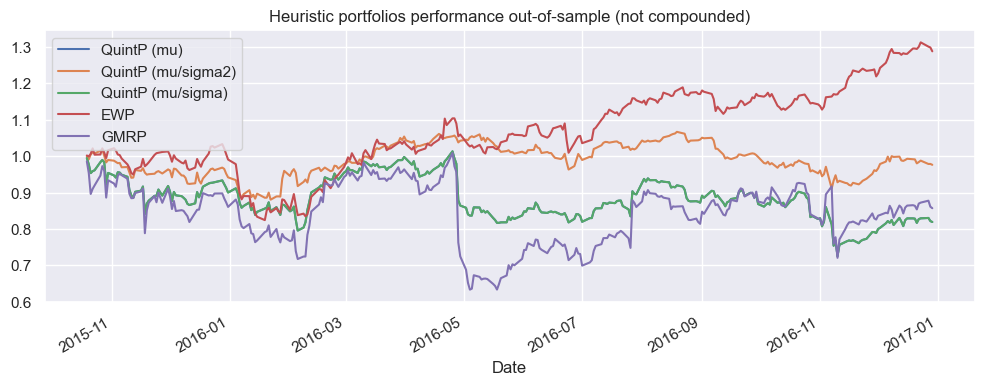

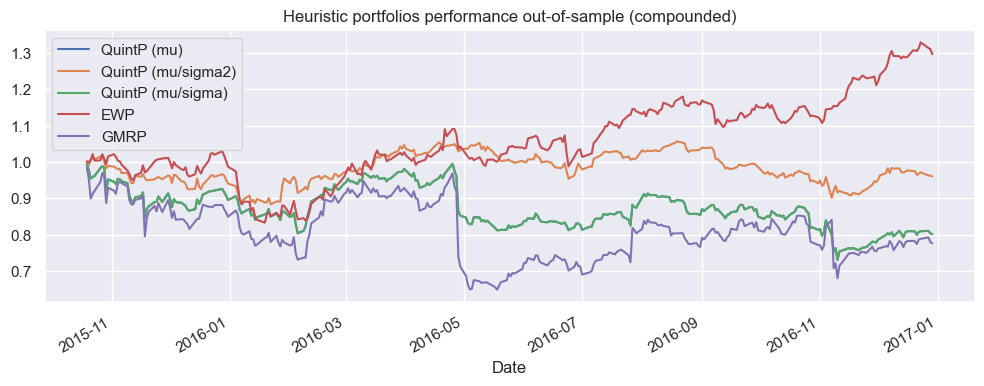

In [69]:
# plots out-of-sample
fig, ax = plt.subplots(figsize=(12,4))
wealth_arith_heuristic_tst.plot(title="Heuristic portfolios performance out-of-sample (not compounded)", ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(12,4))
wealth_geom_heuristic_tst.plot(title="Heuristic portfolios performance out-of-sample (compounded)", ax=ax)
plt.show()

## Markowitz's MVP <a id="markowitz-mvp"></a>
Markowitz's mean-variance portfolio (MVP) with no shorting is formulated as
$$
\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{maximize}} & \boldsymbol{\mu}^T\mathbf{w} -\lambda\mathbf{w}^T\mathbf{\Sigma}\mathbf{w}\\
{\textsf{subject to}}
 & \mathbf{1}^T\mathbf{w} = 1\\
 & \mathbf{w}\ge\mathbf{0}.
\end{array}
$$

This problem does not have a closed-form solution and we need to resort to using a solver. It is very convenient to use the package `cvxpy` (although the computational cost will be high and the solution not totally robust, if necessary use a QP solver like `quadprog`):


In [70]:
def MVP(mu, Sigma, lmd=0.5):
    w = cp.Variable(len(mu))
    variance = cp.quad_form(w, Sigma)
    expected_return = w @ mu
    problem = cp.Problem(cp.Minimize(lmd * variance - expected_return), [w >= 0, cp.sum(w) == 1])   
    problem.solve()
    return w.value
    
# this function can now be used as
w_MVP = MVP(mu, Sigma)

## GMVP <a id="gmvp"></a>
The Global Minimum Variance Portfolio (GMVP) with no shorting is formulated as
$$
\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{minimize}} & \mathbf{w}^T\mathbf{\Sigma}\mathbf{w}\\
{\textsf{subject to}}
 & \mathbf{1}^T\mathbf{w} = 1\\
 & \mathbf{w}\ge\mathbf{0}
\end{array}
$$

Since a closed-form solution does not exist with the constraint $\mathbf{w}\ge\mathbf{0}$, we need to resort to a solver. We can convenientky use the package `cvxpy` (although the computational cost will be high and the solution not totally robust, if necessary use a QP solver like `quadprog`):

In [71]:
# create function for GMVP
def GMVP(Sigma):
    w = cp.Variable(len(mu))
    variance = cp.quad_form(w, Sigma)
    problem = cp.Problem(cp.Minimize(variance), [w >= 0, cp.sum(w) == 1])   
    problem.solve()
    return w.value
    
# this function can now be used as
w_GMVP = GMVP(Sigma)

## MSRP <a id="msrp"></a>
### MSRP via nonlinear solver
The maximum Sharpe ratio portfolio (MSRP) is given by the solution to the nonconvex problem
$$\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{maximize}} &
\dfrac{\mathbf{w}^{T}\boldsymbol{\mu}}{\sqrt{\mathbf{w}^{T}\boldsymbol{\Sigma}\mathbf{w}}}\\
\textsf{subject to} & \mathbf{1}^{T}\mathbf{w}=1, \quad\mathbf{w}\geq\mathbf{0}.
\end{array}$$

We will solve this problem with the general-purpose nonlinear solver `minimize` available in SciPy:

In [72]:
# define the nonconvex objective function
def fn_SR(w, mu, Sigma):
    x = w.reshape((-1, 1)) 
    return ((w @ mu)/np.sqrt(x.T @ Sigma @ x))[0]
  
# initial point
w0 = np.ones(N)/N

# define lower bounds for inequality constraints
ub = np.inf * np.ones(N)
lb = np.zeros(N)
A = np.eye(N)
ineq_lc = LinearConstraint(A=A, lb=lb, ub=ub)

# define equality constraints
eq_lc = LinearConstraint(A=np.ones(N), lb=1, ub=1)

# call solver
res = minimize(lambda x, *args: -fn_SR(x, *args), w0, args=(mu, Sigma), constraints=[ineq_lc, eq_lc])
print(res)
w_nonlinear_solver = res.x
pd.DataFrame({"w_nonlinear_solver": np.round(w_nonlinear_solver, 3)}, index=stock_namelist)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.1143597074027014
       x: [ 2.132e-18 -6.589e-17  9.297e-03  3.356e-17  9.072e-17
            5.547e-02 -2.366e-17  7.698e-01  1.655e-01]
     nit: 11
     jac: [ 5.358e-02  5.606e-02  6.101e-04  2.307e-02  1.064e-01
            4.983e-05  1.964e-02  5.312e-05 -3.049e-04]
    nfev: 111
    njev: 11


,w_nonlinear_solver
AAPL,0.000
AMD,-0.000
ADI,0.009
A,0.000
MOH,0.000
CVS,0.055
APD,-0.000
AA,0.770
CF,0.165


### MSRP via bisection
We are going to solve the nonconvex problem
$$\begin{array}{ll}
\underset{\mathbf{w},t}{\textsf{maximize}} & t\\
\textsf{subject to}
& t \leq \dfrac{\mathbf{w}^{T}\boldsymbol{\mu}}{\sqrt{\mathbf{w}^{T}\boldsymbol{\Sigma}\mathbf{w}}}\\
& \mathbf{1}^{T}\mathbf{w}=1, \quad\left(\mathbf{w}\geq\mathbf{0}\right).
\end{array}$$
via bisection on $t$ with the following (convex) SOCP problem for a given $t$:
$$\begin{array}{ll}
\underset{\;}{\textsf{find}} & \mathbf{w}\\
\textsf{subject to}
& t \left\Vert \boldsymbol{\Sigma}^{1/2}\mathbf{w}\right\Vert_{2}\leq\mathbf{w}^{T}\boldsymbol{\mu}\\
& \mathbf{1}^{T}\mathbf{w}=1, \quad\left(\mathbf{w}\geq\mathbf{0}\right).
\end{array}$$

In [90]:
Sigma_12 = np.linalg.cholesky(Sigma)

def SOCP_bisection(t):
    w = cp.Variable(Sigma_12.shape[0])
    constraints = [t*cp.norm(Sigma_12 @ w, 2) <= mu @ w,  w >= 0, cp.sum(w) == 1]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve(solver=cp.ECOS, feastol=1e-06)
    return w.value

# now run the bisection algorithm
t_lb = 0
t_ub = 10
while(t_ub - t_lb > 1e-7):
    t = .5 * (t_lb + t_ub)
    if (SOCP_bisection(t) is None): # test whether the problem is infeasible
        t_ub = t
    else:
        t_lb = t
w_bisection = SOCP_bisection(t_lb)
pd.DataFrame({"w_nonlinear_solver": np.round(w_nonlinear_solver, 3),
              "w_bisection": np.round(w_bisection, 3)}, index=stock_namelist)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jun 27 12:25:44 PM: Your problem has 9 variables, 11 constraints, and 0 parameters.
(CVXPY) Jun 27 12:25:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 27 12:25:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 27 12:25:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 27 12:25:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 27 12:25:44 PM: Compiling problem (target solver=CLARABEL).


SolverError: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.

Let's check the objective function for the nonlinear solver and the bisection methods:

In [74]:
pd.DataFrame({"nonlinear_solver": fn_SR(w_nonlinear_solver, mu, Sigma),
              "bisection": fn_SR(w_bisection, mu, Sigma)}, index=['Sharpe ratio'])

,nonlinear_solver,bisection
Sharpe ratio,0.11436,0.1114


As we can observe, the nonlinear solver gives a better solution.

Now, let's implement the Dinkelbach algorithm:

In [75]:
Sigma_12 = np.linalg.cholesky(Sigma)

def SOCP_Dinkelbach(y):
    w = cp.Variable(Sigma_12.shape[0])
    constraints = [w >= 0, cp.sum(w) == 1]
    problem = cp.Problem(cp.Maximize(mu @ w - y * cp.norm(Sigma_12 @ w, 2)), constraints)
    problem.solve(solver=cp.ECOS)
    return w.value

# initial point (has to satisfy w_k.T @ mu>=0)
i_max = np.argmax(mu)
w_k = np.zeros(N)
w_k[i_max] = 1
w_prev = np.zeros(N)

# now the iterative Dinkelbach algorithm
k = 0
while(np.max(np.abs(w_k - w_prev)) > 1e-6):
    w_prev = np.copy(w_k)
    y_k = (w_k @ mu) / np.sqrt(w_k.T @ Sigma @ w_k)
    w_k = SOCP_Dinkelbach(y_k)
    k = k + 1
w_Dinkelbach = w_k
pd.DataFrame({"w_nonlinear_solver": np.round(w_nonlinear_solver, 3),
              "w_bisection": np.round(w_bisection, 3),
              "w_Dinkelbach": np.round(w_Dinkelbach, 3)}, index=stock_namelist)

/Users/palomar/.virtualenvs/book-python-code3.9/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


,w_nonlinear_solver,w_bisection,w_Dinkelbach
AAPL,0.000,0.000,0.000
AMD,-0.000,0.000,0.000
ADI,0.009,0.045,0.028
A,0.000,0.006,0.000
MOH,0.000,0.000,0.000
CVS,0.055,0.156,0.147
APD,-0.000,0.037,0.011
AA,0.770,0.633,0.667
CF,0.165,0.123,0.146


In [76]:
pd.DataFrame({"nonlinear_solver": fn_SR(w_nonlinear_solver, mu, Sigma),
              "bisection": fn_SR(w_bisection, mu, Sigma),
              "Dinkelbach": fn_SR(w_Dinkelbach, mu, Sigma)}, index=['Sharpe ratio'])

,nonlinear_solver,bisection,Dinkelbach
Sharpe ratio,0.11436,0.1114,0.113132


### MSRP via Schaible
The maximum Sharpe ratio portfolio (MSRP) is the nonconvex problem
$$\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{maximize}} &
\dfrac{\mathbf{w}^{T}\boldsymbol{\mu}}{\sqrt{\mathbf{w}^{T}\boldsymbol{\Sigma}\mathbf{w}}}\\
\textsf{subject to} & \mathbf{1}^{T}\mathbf{w}=1, \quad \mathbf{w}\geq\mathbf{0}
\end{array}$$
that can be rewritten in convex form as
$$
\begin{array}{ll}
\underset{\tilde{\mathbf{w}}}{\textsf{minimize}} & \tilde{\mathbf{w}}^T\mathbf{\Sigma}\tilde{\mathbf{w}}\\
{\textsf{subject to}}
 & \tilde{\mathbf{w}}^T\boldsymbol{\mu} = 1\\
 & \tilde{\mathbf{w}}\ge\mathbf{0}
\end{array}
$$
and then $\mathbf{w} = \tilde{\mathbf{w}}/(\mathbf{1}^T\tilde{\mathbf{w}})$.

This is a quadratic problem (QP) and we can conveniently use `cvxpy`
(although one is advised to use a specific QP solver like `quadprog` for speed and stability):


In [77]:
def MSRP(mu, Sigma):
    w = cp.Variable(len(mu))
    variance = cp.quad_form(w, Sigma)
    problem = cp.Problem(cp.Minimize(variance), [w >= 0, w @ mu == 1])   
    problem.solve()
    return w.value/np.sum(w.value)

w_MSRP = MSRP(mu, Sigma)
pd.DataFrame({"w_nonlinear_solver": np.round(w_nonlinear_solver, 3),
              "w_bisection": np.round(w_bisection, 3),
              "w_Dinkelbach": np.round(w_Dinkelbach, 3),
              "w_MSRP": np.round(w_MSRP, 3)}, index=stock_namelist)

,w_nonlinear_solver,w_bisection,w_Dinkelbach,w_MSRP
AAPL,0.000,0.000,0.000,0.000
AMD,-0.000,0.000,0.000,0.000
ADI,0.009,0.045,0.028,0.008
A,0.000,0.006,0.000,0.000
MOH,0.000,0.000,0.000,0.000
CVS,0.055,0.156,0.147,0.056
APD,-0.000,0.037,0.011,0.000
AA,0.770,0.633,0.667,0.771
CF,0.165,0.123,0.146,0.165


Now, let's compare all the algorithms:

In [78]:
pd.DataFrame({"nonlinear_solver": fn_SR(w_nonlinear_solver, mu, Sigma),
              "bisection": fn_SR(w_bisection, mu, Sigma),
              "Dinkelbach": fn_SR(w_Dinkelbach, mu, Sigma),
              "Schaible": fn_SR(w_MSRP, mu, Sigma)}, index=['Sharpe ratio'])

,nonlinear_solver,bisection,Dinkelbach,Schaible
Sharpe ratio,0.11436,0.1114,0.113132,0.11436


As we can observe, the nonlinear solver and the Schaible algorithm give better solutions.

## IVP <a id="ivp"></a>
The Inverse volatility portfolio (IVP) has the simple closed-form solution:
$$\mathbf{w} = \frac{\boldsymbol{\sigma}^{-1}}{\mathbf{1}^T\boldsymbol{\sigma}^{-1}}.$$

Its implementation in Python is trivial:

In [79]:
# create function for IVP
def IVP(Sigma):
  sigma = np.sqrt(np.diag(Sigma))
  w = 1/sigma
  w = w/np.sum(w)
  return w

# this function can now be used as
w_IVP = IVP(Sigma)

## MDP <a id="mdp"></a>
The Most diversified portfolio (MDP) is formulated exactly as the maximum Sharpe ratio portfolio (MSRP) but using $\boldsymbol{\sigma}$ in lieu of $\boldsymbol{\mu}$:
$$\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{maximize}} &
\dfrac{\mathbf{w}^{T}\boldsymbol{\sigma}}{\sqrt{\mathbf{w}^{T}\boldsymbol{\Sigma}\mathbf{w}}}\\
\textsf{subject to} & \mathbf{1}^{T}\mathbf{w}=1\\
 & \mathbf{w}\ge\mathbf{0}.
\end{array}$$

Therefore, we can use the same Python function created to solve the MSRP:

In [80]:
w_MDP = MSRP(np.sqrt(np.diag(Sigma)), Sigma)

## MDCP <a id="mdcp"></a>
The maximum decorrelation portfolio (MDCP) is formally formulated as the GMVP but using $\mathbf{C}$ in lieu of $\boldsymbol{\Sigma}$:
$$\begin{array}{ll}
\underset{\mathbf{w}}{\textsf{minimize}} & \mathbf{w}^{T}\mathbf{C}\mathbf{w}\\
\textsf{subject to} & \mathbf{1}^{T}\mathbf{w}=1
\end{array}$$
where $\mathbf{C} \triangleq \mathsf{Diag}(\boldsymbol{\Sigma})^{-1/2}\boldsymbol{\Sigma}\mathsf{Diag}(\boldsymbol{\Sigma})^{-1/2}$ is the correlation matrix.

Therefore, we can use the same R function created to solve the GMVP:

In [81]:
# create function for MDCP based on GMVP()
def MDCP(Sigma):
    C = np.diag(1/np.sqrt(np.diag(Sigma))) @ Sigma @ np.diag(1/np.sqrt(np.diag(Sigma)))
    return GMVP(Sigma=C)

# this function can now be used as
w_MDCP = MDCP(Sigma)

## Final comparison <a id="final-comparison"></a>

We now compare the portfolios MVP, GMVP, IVP, MSRP, MDP, MDCP, as well as the previous heuristic portfolios (EWP, quintile portfolio, and GMRP) under the underlying constraints $\mathbf{w}\ge\mathbf{0}$ and $\mathbf{1}^T\mathbf{w}=1$). 

Recall the three heuristic portfolios we want to compare:

In [82]:
w_heuristic = pd.DataFrame(np.column_stack([w_QuintP_1, w_EWP, w_GMRP]), columns=['QuintP (mu)', 'EWP', 'GMRP'], index=stock_namelist)
w_heuristic

,QuintP (mu),EWP,GMRP
AAPL,0.0,0.111111,0.0
AMD,0.0,0.111111,0.0
ADI,0.0,0.111111,0.0
A,0.0,0.111111,0.0
MOH,0.0,0.111111,0.0
CVS,0.0,0.111111,0.0
APD,0.0,0.111111,0.0
AA,0.5,0.111111,0.0
CF,0.5,0.111111,1.0


Now we stack the Markowitz-based portfolios we want to compare:

In [83]:
w_markowitz = pd.DataFrame(np.column_stack([w_MVP, w_GMVP, w_MSRP, w_IVP, w_MDP, w_MDCP]), 
                           columns=['MVP', 'GMVP', 'MSRP', 'IVP', 'MDP', 'MDCP'], index=stock_namelist)
w_markowitz

,MVP,GMVP,MSRP,IVP,MDP,MDCP
AAPL,2.085200e-22,0.038864,2.477807e-18,0.125798,0.029495,0.023525
AMD,2.109380e-22,0.025947,5.839048e-18,0.092084,0.109265,0.119057
ADI,2.120751e-22,0.124251,8.354646e-03,0.108142,0.193028,0.179095
A,9.095495e-23,0.038745,1.742380e-18,0.116109,0.010673,0.009223
MOH,-3.012495e-23,0.014300,1.054396e-17,0.056409,0.119176,0.211982
CVS,9.856729e-23,0.140781,5.552711e-02,0.136364,0.062438,0.045941
APD,2.098670e-22,0.085232,4.019966e-18,0.100095,0.155028,0.155401
AA,1.235727e-01,0.502505,7.706601e-01,0.173125,0.184711,0.107050
CF,8.764273e-01,0.029376,1.654581e-01,0.091874,0.136184,0.148726


We can now compare the allocations of the portfolios:

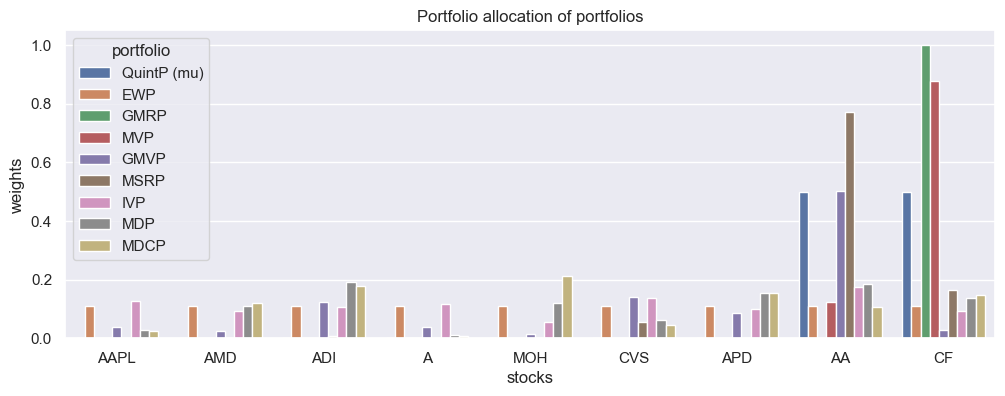

In [84]:
w_all = pd.concat([w_heuristic, w_markowitz], axis=1)

# plot to compare the allocations
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='stocks', y='weights', hue='portfolio', ax=ax,
            data=w_all.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='portfolio', value_name='weights'))
ax.set_title("Portfolio allocation of portfolios")
plt.show()

The performance is (in-sample vs out-of-sample):

In [85]:
# Let's repeat some code here for the sake of completeness
stock_namelist = ["AAPL", "AMD", "ADI", "A", "MOH", "CVS", "APD", "AA", "CF"]
start_date = "2013-01-01"
end_date = "2016-12-31"
prices = yf.download(stock_namelist, start = start_date, end = end_date)

adj_close_prices = prices[['Adj Close']]
adj_close_prices.columns = adj_close_prices.columns.droplevel(0)

prices_mat = np.ascontiguousarray(adj_close_prices) # convert data frame into a numpy array
X_log = np.diff(np.log(prices_mat), axis=0) # compute log-returns and returns
X_lin = np.diff(prices_mat, axis=0) / prices_mat[:-1] # prices_mat[:-1] removes the last row of prices_mat, not inplace
T, N = np.shape(X_log)

T_trn = int(0.7*T)  # 70% of data
X_log_trn = X_log[:T_trn,]
X_log_tst = X_log[T_trn:T,]
X_lin_trn = X_lin[:T_trn,]
X_lin_tst = X_lin[T_trn:T,]

## compute sample statistics
mu_log = np.mean(X_log_trn, axis=0)
Sigma_log = np.cov(X_log_trn.T)

ret_all = X_lin @ np.asarray(w_all)
ret_all_trn = ret_all[:T_trn,]
ret_all_tst = ret_all[T_trn:,]

# convert to dataframes
portfolio_names = np.concatenate((w_heuristic.columns, w_markowitz.columns))
ret_all_df = pd.DataFrame(ret_all, columns=portfolio_names, index=adj_close_prices.index[:-1])
ret_all_trn_df = pd.DataFrame(ret_all_trn, columns=portfolio_names, index=adj_close_prices.index[:T_trn])
ret_all_tst_df = pd.DataFrame(ret_all_tst, columns=portfolio_names, index=adj_close_prices.index[T_trn:-1])
ret_all_df.head()

[*********************100%%**********************]  9 of 9 completed


,QuintP (mu),EWP,GMRP,MVP,GMVP,MSRP,IVP,MDP,MDCP
Date,,,,,,,,,
2013-01-02,-0.019493,-0.008811,-0.040999,-0.035684,-0.003137,-0.005532,-0.007228,-0.009578,-0.011395
2013-01-03,0.023096,0.013028,0.041974,0.037309,0.004889,0.010710,0.010263,0.012898,0.017112
2013-01-04,0.005808,0.001167,0.010817,0.009579,-0.000630,0.002306,-0.000408,0.001459,0.004365
2013-01-07,-0.013607,-0.006183,-0.023616,-0.021143,-0.003867,-0.006555,-0.005920,-0.005864,-0.005892
2013-01-08,0.004880,0.005534,0.001134,0.002060,0.007982,0.007453,0.007294,0.003738,0.001521


In [86]:
# compute performance measures
pd.DataFrame({"Sharpe ratio (in-sample)":     ret_all_trn_df.apply(emp.sharpe_ratio).apply(lambda x: f"{x:.3}"),
              "Sharpe ratio (out-of-sample)": ret_all_tst_df.apply(emp.sharpe_ratio).apply(lambda x: f"{x:.3}"),
              "Annual return (in-sample)":     ret_all_trn_df.apply(emp.annual_return).apply(lambda x: f"{x:.2%}"),
              "Annual return (out-of-sample)": ret_all_tst_df.apply(emp.annual_return).apply(lambda x: f"{x:.2%}"),
              "Annual volatility (in-sample)":     ret_all_trn_df.apply(emp.annual_volatility).apply(lambda x: f"{x:.2%}"),
              "Annual volatility (out-of-sample)": ret_all_tst_df.apply(emp.annual_volatility).apply(lambda x: f"{x:.2%}"),
             })

,Sharpe ratio (in-sample),Sharpe ratio (out-of-sample),Annual return (in-sample),Annual return (out-of-sample),Annual volatility (in-sample),Annual volatility (out-of-sample)
QuintP (mu),1.73,-0.583,37.80%,-16.81%,19.62%,25.78%
EWP,1.08,1.11,17.79%,24.15%,16.38%,21.69%
GMRP,1.27,-0.283,40.88%,-18.98%,30.71%,42.04%
MVP,1.36,-0.338,40.39%,-18.05%,27.66%,37.51%
GMVP,1.67,-0.211,25.20%,-4.84%,14.03%,16.79%
MSRP,1.94,-0.741,33.58%,-15.83%,15.58%,20.42%
IVP,1.24,0.745,19.50%,13.09%,15.32%,18.90%
MDP,1.19,0.838,19.73%,17.50%,16.24%,22.17%
MDCP,0.932,1.31,16.87%,37.72%,18.57%,27.24%


We can observe that:

- as expected, the MSRP achieves the maximum ex ante (in-sample) Sharpe ratio; however, this is not maintained ex post (out-of-sample);
- as expected, the EWP achieves the best ex post performance;
- the MVP performs poorly;
- other top performers include the IVP and MDP.

Let's plot the geometric wealth evolution over the out-of-sample time:


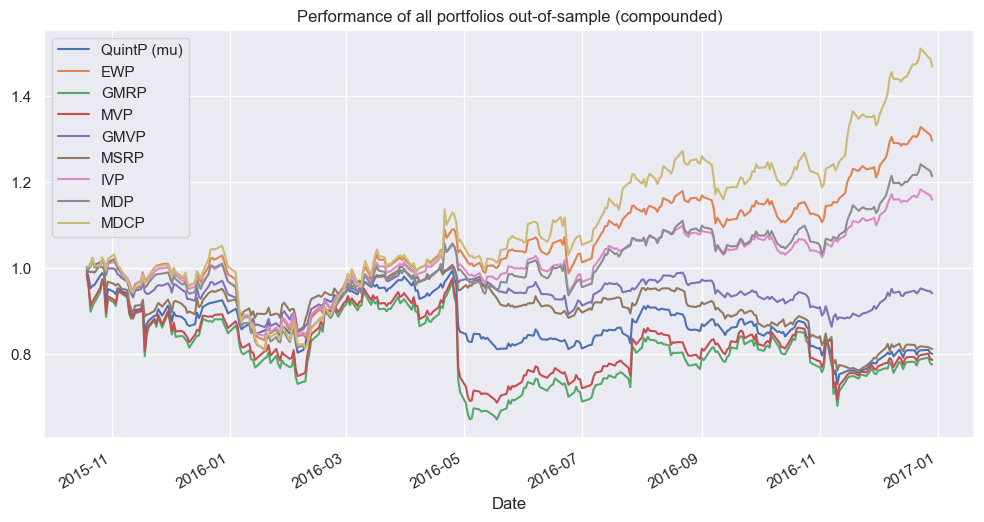

In [87]:
fig, ax = plt.subplots(figsize=(12,6))
wealth_geom_all_tst = np.cumprod(1 + ret_all_tst_df)
wealth_geom_all_tst.plot(title="Performance of all portfolios out-of-sample (compounded)", ax=ax)
plt.show()

Interestingly, we can observe two distinguishable sets of portfolio when it comes to their final performance. The first set of portfolios comprised by MDCP, EWP, MDP, and IVP present a superior performance by outputting a higher wealth value than their starting budget. Whereas the Quintile, GMVP, MVP, MSRP, and GMRP present unacceptable performances.